# Frequency-switched Data Reduction
-----------------------------------

This notebook shows how to use `dysh` to calibrate a frequency switched observations. The idea is similar to an OnOff observation, except the telescope does not move to an Off in position, but move their IF in frequency space. Here we call the On/Off the Sig and Ref. Since the telescope observes in a Track mode, combining the sig and a shifted (folded) ref, a $\sqrt{2}$ improvement in S/N can be achieved.

It retrieves and calibrates frequency-switched scans using `GBTFITSLoad.getfs()`, which returns a `ScanBlock` object.  

In [1]:
import os
import wget
import astropy.units as u
from dysh.fits.gbtfitsload import GBTFITSLoad
import dysh.util as util
import numpy as np

In [2]:
# helper function to show the mean and dispersion for data and 1-rolled data
def rolled_stats(data):
    delta = data[1:] - data[:-1]
    print(data.mean(), data.std(), delta.mean(), delta.std())

# rolled_stats(np.random.normal(0,1,10000))

## First, we download the example SDFITS data, if necessary.


In [3]:
filename = "AGBT20B_014_03.raw.vegas.A.fits"
if not os.path.isfile(filename):
    url = f"http://www.gb.nrao.edu/dysh/example_data/fs-L/data/AGBT20B_014_03.raw.vegas/{filename}"
    print(f"Downloading {filename}")
    wget.download(url,out=filename)
    print(f"\nRetrieved {filename}")
else:
    print(f"{filename} already downloaded")

AGBT20B_014_03.raw.vegas.A.fits already downloaded


In [4]:
sdfits = GBTFITSLoad(filename)
sdfits.info()
sdfits.summary()

Filename: AGBT20B_014_03.raw.vegas.A.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      12   ()      
  1  SINGLE DISH    1 BinTableHDU    245   352R x 74C   ['32A', '1D', '22A', '1D', '1D', '1D', '16384E', '16A', '6A', '8A', '1D', '1D', '1D', '4A', '1D', '4A', '1D', '1I', '32A', '32A', '1J', '32A', '16A', '1E', '8A', '1D', '1D', '1D', '1D', '1D', '1D', '1D', '1D', '1D', '1D', '1D', '1D', '8A', '1D', '1D', '12A', '1I', '1I', '1D', '1D', '1I', '1A', '1I', '1I', '16A', '16A', '1J', '1J', '22A', '1D', '1D', '1I', '1A', '1D', '1E', '1D', '1D', '1D', '1D', '1D', '1A', '1A', '8A', '1E', '1E', '16A', '1I', '1I', '1I']   


,SCAN,OBJECT,VELOCITY,PROC,PROCSEQN,RESTFREQ,DOPFREQ,# IF,# POL,# INT,# FEED,AZIMUTH,ELEVATIO
0,6,M33S,0.0,Track,1,1.606184,1.420405,4,2,11,1,72.712573,28.957453


### Now retrieve and calibrate the frequency-switched scan
The default is to fold the sig and ref to create the final spectrum.  Use `fold=False` to not fold them and `use_sig=False` to reverse the role of sig and ref.

In [5]:
fsscan = sdfits.getfs(scan=6, ifnum=0, plnum=1)

/home/teuben/GBT/dysh/src/dysh/spectra/core.py:349: RuntimeWarning: Mean of empty slice
  meandiff = np.nanmean(calon[chrng] - caloff[chrng])


In [6]:
ta = fsscan.timeaverage(weights='tsys')

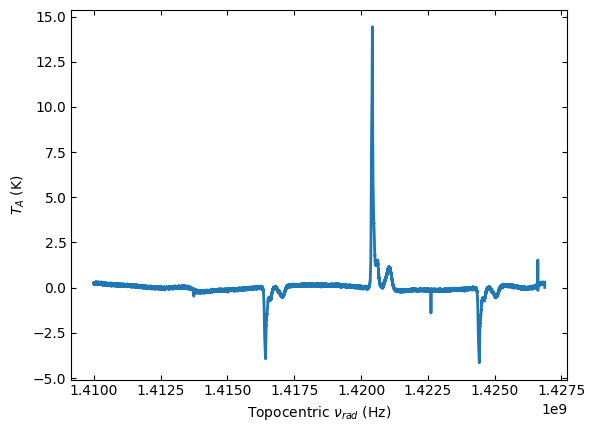

In [7]:
ta.plot()

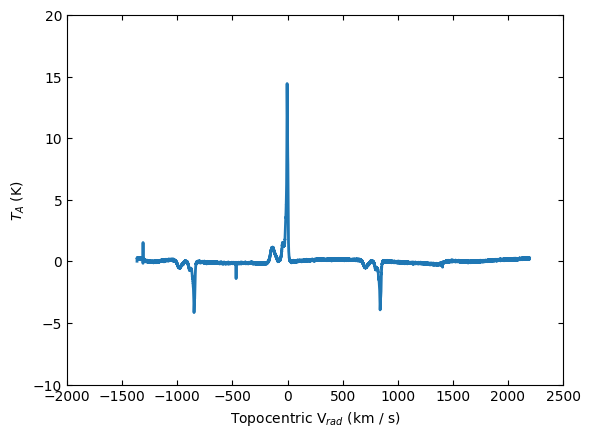

In [8]:
ta.plot(xaxis_unit="km/s",yaxis_unit="K",ymin=-10,ymax=20,xmin=-2000,xmax=2500)

### Plot x axis in channel units and remove a baseline with a compound inclusion region.

For baseline subtraction either include= or exclude can be used, but not both.
Right now, such compound regions only work in channel space. 

Also note the default is a polynomial model, for which we need to normalize the frequency axis in channel space.

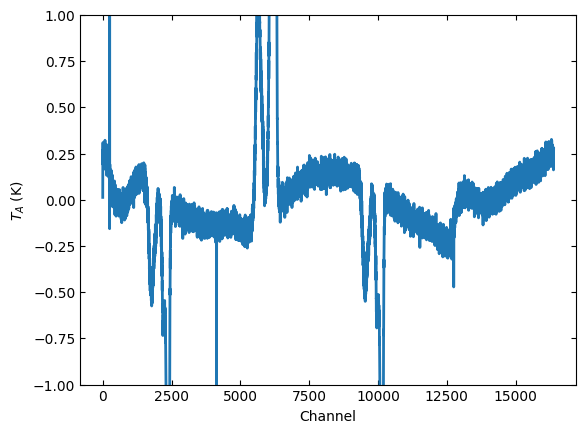

-0.142315958298121 K 0.03631059232266146 K -0.00010205442179552853 K 0.04198114224875007 K
EXCLUDING [Spectral Region, 1 sub-regions:
  (0.0 Hz, 4200.0 Hz) , Spectral Region, 1 sub-regions:
  (5300.0 Hz, 6600.0 Hz) , Spectral Region, 1 sub-regions:
  (7600.0 Hz, 16383.0 Hz) ]


AttributeError: 'str' object has no attribute 'param_names'

In [9]:

ta.plot(xaxis_unit="chan",yaxis_unit="K",ymin=-1,ymax=1)
rolled_stats(ta.flux[4200:5300])
ta.baseline(degree=2,include=[(4200,5300),(6600,7600)], remove=True, normalize=True)
rolled_stats(ta.flux[4200:5300])


In [ ]:
ta.plot(ymin=-1,ymax=1,xaxis_unit='channel')

In [ ]:
print(ta.baseline_model)

because we fitted in channel space, the units shown here are /Hz, but should be printed as /chan.

An alternative is to choose other models (e.g. chebychev) which normalize internally to unity.

In [ ]:
ta.savefig("baselined_removed.png")

---

### Now do the calibration using selection

In [ ]:
sdfits.select(scan=6,ifnum=0)

In [ ]:
fsscan2=sdfits.getfs(plnum=1)

In [ ]:
fsscan2.timeaverage().plot()

### Get the other polarization and plot

In [ ]:
fsscan3=sdfits.getfs(plnum=0)

In [ ]:
fsscan3.timeaverage().plot()

### Average the polarizations

In [ ]:
avg = fsscan2.timeaverage()+fsscan3.timeaverage()
avg *= 0.5
avg.plot(ymin=-1,ymax=1)
rolled_stats(avg.flux[3000:5000])

Now we can do the baseline correction again

In [ ]:

avg.baseline(degree=2,include=[(4200,5300),(6600,7600)], remove=True, normalize=True)
avg.plot(ymin=-1,ymax=1)


## Behind the scenes:   raw spectra

Take it from us, the spectra are organized in batches of 4, and the first two are the "sig" calon/caloff, followed by the "ref" calon/caloff. Let's get the first 4 spectra and find out how frequency shifting works.


In [ ]:
r0 = sdfits.getspec(0)
r1 = sdfits.getspec(1)
r2 = sdfits.getspec(2)
r3 = sdfits.getspec(3)

Let's only plot the "sig" and "ref" as the calon/off are nearly identical.  You will see below that there is a birdie or bad channel in the "ref" spectrum, luckily not where the source (M33) is, so it should not pollute the subsequent calibration.

In a followup to this notebook, we shall find out how to identify this bad channel and mask it out. For now, lets carry on.

In [ ]:
r0.plot(title='spectrum 0 (sig)', xaxis_unit="chan")
r2.plot(title='spectrum 2 (ref)', xaxis_unit="chan")


The calibration of a  calon/caloff for each of the sig and cal follows the same procedure as a **gettp()** call. More on this later.
